In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# various backends from qibo and providers
from qibo.backends import NumpyBackend, PyTorchBackend
from qibojit.backends import NumbaBackend
from qiboml.backends import TensorflowBackend

# qibo objects
import qibo
from qibo import hamiltonians

# qiboml models, operations and frontends constructors
from qiboml.models import encoding, ansatze, decoding
from qiboml.operations.differentiation import PSR
from qiboml.interfaces import pytorch as torch_interface

In [51]:
from importlib import reload
reload(ansatze)
reload(encoding)
reload(decoding)
reload(torch_interface)

<module 'qiboml.interfaces.pytorch' from '/home/matteo/Documents/PhD/qiboml/src/qiboml/interfaces/pytorch.py'>

In [52]:
np.random.seed(42)

In [53]:
import numpy as np

def generate_data(n, function: callable = lambda x: np.sin(x)):
    """Generate data."""
    x = np.sort(np.random.uniform(-np.pi, np.pi, n))
    y = function(x) + np.random.normal(0, 0.01, n)
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    return np.array(x), np.array(y)


def train_model(model, data, labels, epochs, nmessage=1):
    """Train model using Binary Cross Entropy loss without sigmoid activation,
       classifying outputs based on positive and negative values."""
    
    # Define the optimizer and the loss function for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_f = torch.nn.MSELoss()  # Use MSELoss for regression
    mse_losses = []
    
    for ep in range(epochs):
        avg_loss = 0.0
    
        for x, y in zip(data, labels):
            optimizer.zero_grad()
            prediction = model(x)  # Get model predictions
    
            # Calculate MSE loss
            loss = loss_f(prediction, y)  
            
            # Perform backward pass and optimization step
            loss.backward()
            optimizer.step()
    
            avg_loss += loss.item()  # Accumulate loss
    
        avg_loss /= len(data)  # Calculate average loss for the epoch
        mse_losses.append(avg_loss)
    
        if (ep + 1) % nmessage == 0:
            print(f"Epoch {ep + 1}: avg MSE loss: {avg_loss:.4f}")

    return mse_losses


def predict_sample(model, data):
    predictions = []
    for x in data:
        predictions.append(model(x).detach().numpy()[0])
    return predictions

In [54]:
target = lambda x : np.sin(x)**2 
data, labels = generate_data(60, target)

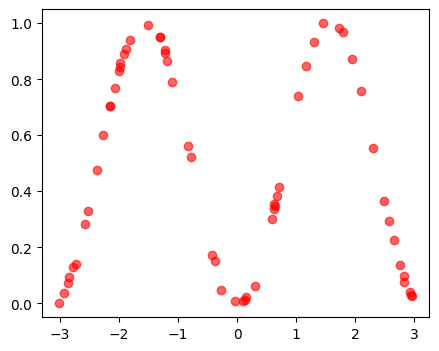

In [55]:
plt.figure(figsize=(5,4))
plt.scatter(data, labels, color="red", alpha=0.6)

In [56]:
data = torch.tensor(data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

In [57]:
# This is quite ambiguous
qibo.set_backend("numpy")
backend = NumpyBackend()
frontend = torch_interface

[Qibo 0.2.14|INFO|2024-11-06 11:17:15]: Using numpy backend on /CPU:0


In [58]:
ndim = 1
nqubits = 1
qubits = [0]
nshots = 100

In [59]:
obs = hamiltonians.Z(nqubits=nqubits)

In [60]:
encoding_layer = encoding.ReuploadingEncoding(
    nqubits = nqubits,
    nlayers = 3,
    qubits = qubits,
    data_shape = (1,)
)
training_layer = ansatze.layered_ansatz(
    nqubits = nqubits,
    qubits = qubits,
    entanglement=False,
) 
decoding_layer = decoding.Expectation(
    nqubits=nqubits,
    qubits=qubits,
    backend=backend,
    observable=obs,
    nshots=nshots,
)

In [61]:
q_model = frontend.QuantumModel(
    encoding=encoding_layer, 
    trainable_circuit=training_layer, 
    decoding=decoding_layer,
    differentiation_rule=PSR(),
)

In [62]:
q_model.trainable_parameters

Parameter containing:
tensor([0.5702, 0.8267, 0.0026, 0.2165, 0.7609, 0.5752, 0.1297, 0.9711, 0.7524,
        0.1197], requires_grad=True)

In [63]:
q_model.draw()

q0: ─RY─RZ─RX─RY─RZ─RX─RY─RZ─RX─RY─RZ─RY─RZ─


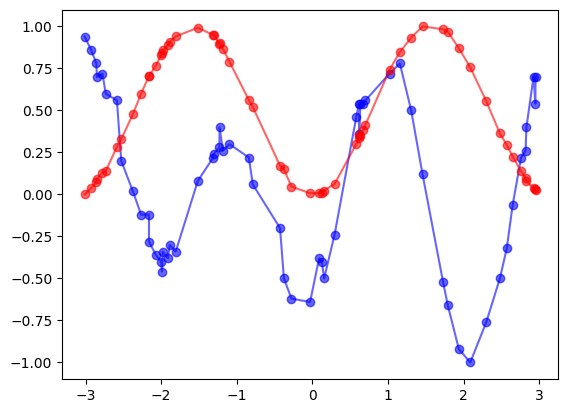

In [64]:
preds = predict_sample(q_model, data)
plt.plot(data, preds, marker="o", color="blue", alpha=0.6)
plt.plot(data, labels, marker="o", color="red", alpha=0.6)

In [65]:
losses = train_model(model=q_model, data=data, labels=labels, epochs=50, nmessage=1)

Epoch 1: avg MSE loss: 0.6877
Epoch 2: avg MSE loss: 0.6068
Epoch 3: avg MSE loss: 0.5659
Epoch 4: avg MSE loss: 0.5095
Epoch 5: avg MSE loss: 0.4963
Epoch 6: avg MSE loss: 0.4478
Epoch 7: avg MSE loss: 0.4609
Epoch 8: avg MSE loss: 0.3800
Epoch 9: avg MSE loss: 0.3692
Epoch 10: avg MSE loss: 0.3422
Epoch 11: avg MSE loss: 0.3407
Epoch 12: avg MSE loss: 0.3165
Epoch 13: avg MSE loss: 0.2834
Epoch 14: avg MSE loss: 0.2834
Epoch 15: avg MSE loss: 0.2413
Epoch 16: avg MSE loss: 0.2566
Epoch 17: avg MSE loss: 0.2411
Epoch 18: avg MSE loss: 0.2181
Epoch 19: avg MSE loss: 0.2048
Epoch 20: avg MSE loss: 0.1715
Epoch 21: avg MSE loss: 0.1397
Epoch 22: avg MSE loss: 0.1321
Epoch 23: avg MSE loss: 0.1237
Epoch 24: avg MSE loss: 0.1057
Epoch 25: avg MSE loss: 0.1058
Epoch 26: avg MSE loss: 0.0902
Epoch 27: avg MSE loss: 0.0670
Epoch 28: avg MSE loss: 0.0667
Epoch 29: avg MSE loss: 0.0632
Epoch 30: avg MSE loss: 0.0603
Epoch 31: avg MSE loss: 0.0514
Epoch 32: avg MSE loss: 0.0529
Epoch 33: avg MSE

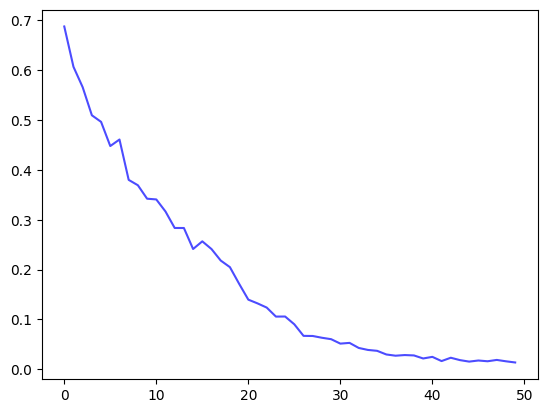

In [66]:
plt.plot(losses, color="blue", alpha=0.7)

In [67]:
d = q_model(data[0])

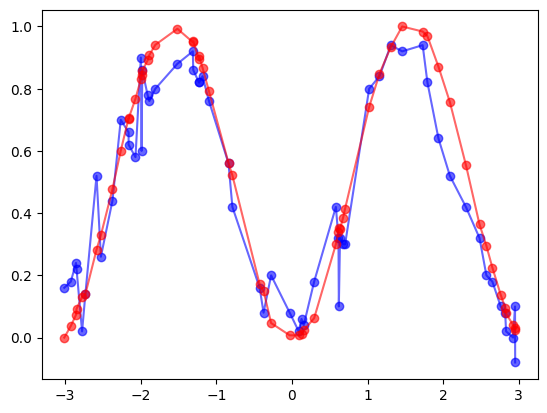

In [68]:
preds = predict_sample(q_model, data)
plt.plot(data, preds, marker="o", color="blue", alpha=0.6)
plt.plot(data, labels, marker="o", color="red", alpha=0.6)